# Find Similarities between students and cohorts
***Matt Paterson***<br>
***Machine Learning Engineer***<br>
***Santa Cruz, California***<br>
***10/16/2021***<br>

In this challenge, I'll take four csv's with raw data about users of a platform who view videos, review the videos, and also voluntarily submit their interests in the videos, as well as the videos and video authors. 

I will create a model and api that allows an administrator/user (comapny) to input a user_handle (customer) from the existing group of user_handle(s) and get an output of the closest users to the input user_handle.

To get there, 
- I will use a simple cosine similarity score for the users, 
- run a dbscan or heirarchical clustering model as an additional input column,
- employ some Natural Language Processing techniques to find 
    - similar course tags and 
    - interest tags and 
    - assessment tags where they are inconsistent, and will 
- utilize scikit-learn's OneHotEncoder to quickly vectorize categorical data

I will then create a lookup table in DynamoDB that can store the resulting users table, allowing a RESTful API to query the database through Amazon API Gateway through the depoloyment of an Amazon SageMaker Model Endpoint.

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity
# Before final push, add any imports that come later in this program to this top box

## Load `course_tags.csv`, `user_assessment_scores.csv`, `user_course_views.csv`, and `user_interests.csv`
---

In [2]:
courses = pd.read_csv('../data/course_tags.csv')
print("courses.shape is", courses.shape)
courses.head()

courses.shape is (11337, 2)


,course_id,course_tags
0,12-principles-animation-toon-boom-harmony-1475,2d-animation
1,2d-racing-game-series-unity-5-1312,game-design
2,2d-racing-games-unity-volume-2-1286,game-art
3,2d-racing-games-unity-volume-2-1286,digital-painting
4,2d-racing-games-unity-volume-2-1286,image-editing


In [3]:
courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11337 entries, 0 to 11336
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   course_id    11337 non-null  object
 1   course_tags  11225 non-null  object
dtypes: object(2)
memory usage: 177.3+ KB


In [4]:
courses.isna().sum()

course_id        0
course_tags    112
dtype: int64

In [5]:
len(courses.course_id.value_counts())

5942

In [8]:
len(courses.course_tags.value_counts())

998

In [6]:
assess = pd.read_csv('../data/user_assessment_scores.csv')
print("assess.shape is", assess.shape)
assess.head()

assess.shape is (6571, 4)


,user_handle,assessment_tag,user_assessment_date,user_assessment_score
0,7487,angular-js,2017-08-11 19:03:38,134
1,7487,css,2017-08-11 20:09:56,38
2,7487,html5,2017-07-31 18:59:37,84
3,7487,java,2017-07-31 18:49:27,149
4,7487,javascript,2017-07-31 19:05:03,92


## Think through what we're looking at:
- We have an assessment_tag, a course_tag, and an interest_tag that are not neccessarily consistent, but do tend to marry the interests of the users with their assessement score accross the four datasets
- What if we marry the tags? Just to get an MVP coded up?


In [9]:
assess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6571 entries, 0 to 6570
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_handle            6571 non-null   int64 
 1   assessment_tag         6571 non-null   object
 2   user_assessment_date   6571 non-null   object
 3   user_assessment_score  6571 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 205.5+ KB


In [10]:
assess

,user_handle,assessment_tag,user_assessment_date,user_assessment_score
0,7487,angular-js,2017-08-11 19:03:38,134
1,7487,css,2017-08-11 20:09:56,38
2,7487,html5,2017-07-31 18:59:37,84
3,7487,java,2017-07-31 18:49:27,149
4,7487,javascript,2017-07-31 19:05:03,92
...,...,...,...,...
6566,958,node-js,2017-04-26 20:36:35,245
6567,8887,angular-js,2016-09-30 22:30:48,221
6568,8887,docker,2017-03-24 17:55:06,148
6569,8887,html5,2017-02-10 16:38:53,241


In [11]:
assess = assess.drop(columns=['user_assessment_date'])

In [12]:
assess.head(1)

,user_handle,assessment_tag,user_assessment_score
0,7487,angular-js,134


In [13]:
views = pd.read_csv('../data/user_course_views.csv')
print("views.shape is", views.shape)
views.head()

views.shape is (249238, 6)


,user_handle,view_date,course_id,author_handle,level,view_time_seconds
0,1,2017-06-27,cpt-sp2010-web-designers-branding-intro,875,Beginner,3786
1,1,2017-06-28,cpt-sp2010-web-designers-branding-intro,875,Beginner,1098
2,1,2017-06-28,cpt-sp2010-web-designers-css,875,Intermediate,4406
3,1,2017-07-27,cpt-sp2010-web-designers-css,875,Intermediate,553
4,1,2017-09-12,aws-certified-solutions-architect-professional,281,Advanced,102


In [14]:
views[views['course_id']=='wpf-advanced-topics'].shape

(34, 6)

In [15]:
views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249238 entries, 0 to 249237
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_handle        249238 non-null  int64 
 1   view_date          249238 non-null  object
 2   course_id          249238 non-null  object
 3   author_handle      249238 non-null  int64 
 4   level              249238 non-null  object
 5   view_time_seconds  249238 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 11.4+ MB


In [16]:
interests = pd.read_csv('../data/user_interests.csv')
print("interests.shape is", interests.shape)
interests.head()

interests.shape is (297526, 3)


,user_handle,interest_tag,date_followed
0,1,mvc-scaffolding,2017-06-27 16:26:52
1,1,mvc2,2017-06-27 16:26:52
2,1,mvc-html-helpers,2017-06-27 16:26:52
3,1,mvc4-ioc,2017-06-27 16:26:52
4,1,mvc-testing,2017-06-27 16:26:52


In [17]:
interests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297526 entries, 0 to 297525
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_handle    297526 non-null  int64 
 1   interest_tag   297526 non-null  object
 2   date_followed  297526 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.8+ MB


## Drop unnecessary columns
---

For this first run through, drop all of the null values from courses as there are a small number of them--112/11337

In [18]:
courses = courses.dropna()

## Merge into a single dataframe
---

Use the user_handle column to merge three of the dataframes and course_id to merge the other

look at them severally before trying to merge them all


In [22]:
def make_dfs():
    '''
    return updated list with each df for parsing
    '''
    return [courses, assess, views, interests]

In [23]:
dfs=make_dfs()
df_names=['courses', 'assess', 'views', 'interests']

In [24]:
for df in dfs:
    print(df.shape)

(11225, 2)
(6571, 3)
(249238, 6)
(297526, 3)


In [25]:
for i in range(len(dfs)):
    print("***" + df_names[i] + "***")
    print(dfs[i].dtypes)

***courses***
course_id      object
course_tags    object
dtype: object
***assess***
user_handle               int64
assessment_tag           object
user_assessment_score     int64
dtype: object
***views***
user_handle           int64
view_date            object
course_id            object
author_handle         int64
level                object
view_time_seconds     int64
dtype: object
***interests***
user_handle       int64
interest_tag     object
date_followed    object
dtype: object


In [40]:
# Try to make a dataframe merging interests to assess on the tags and user_handle
pd.merge(left=interests, right=assess, how='outer', left_on=['user_handle', 'interest_tag'], right_on=['user_handle', 'assessment_tag']).isna().sum()

user_handle                   0
interest_tag               4291
date_followed              4291
assessment_tag           294129
user_assessment_score    294129
dtype: int64

In [41]:
assess.head(1)

,user_handle,assessment_tag,user_assessment_score
0,7487,angular-js,134


How many unique tags exist in each dataframe?

In [42]:
tags = len(courses.course_tags.value_counts())
ids = len(courses.course_id.value_counts())

print(f"There are {tags} unique course tags")
print(f"There are {ids} unique course ids")

There are 998 unique course tags
There are 5830 unique course ids


In [43]:
views.columns

Index(['user_handle', 'view_date', 'course_id', 'author_handle', 'level',
       'view_time_seconds'],
      dtype='object')

In [44]:
assess.columns

Index(['user_handle', 'assessment_tag', 'user_assessment_score'], dtype='object')

In [45]:
assess_tags = len(assess.assessment_tag.value_counts())

print(f"There are {assess_tags} unique assessment tags")


There are 54 unique assessment tags


In [46]:
interest_tags = len(interests.interest_tag.value_counts())

print(f"There are {interest_tags} unique interest tags")


There are 748 unique interest tags


In [47]:
for df in dfs:
    print(df.columns)

Index(['course_id', 'course_tags'], dtype='object')
Index(['user_handle', 'assessment_tag', 'user_assessment_score'], dtype='object')
Index(['user_handle', 'view_date', 'course_id', 'author_handle', 'level',
       'view_time_seconds'],
      dtype='object')
Index(['user_handle', 'interest_tag', 'date_followed'], dtype='object')


In [48]:
df_names

['courses', 'assess', 'views', 'interests']

In [49]:
assess.shape

(6571, 3)

In [50]:
views.shape

(249238, 6)

In [51]:
pd.merge(left=views, right=assess, left_on='user_handle', right_on='user_handle').head() #.shape

,user_handle,view_date,course_id,author_handle,level,view_time_seconds,assessment_tag,user_assessment_score
0,2,2017-05-01,arnold-maya-fundamentals,273,Beginner,3277,photoshop,139
1,2,2017-05-08,animated-web-social-media-banners-photoshop-fl...,62,Advanced,1996,photoshop,139
2,2,2017-05-08,arnold-maya-fundamentals,273,Beginner,2612,photoshop,139
3,2,2017-05-09,arnold-maya-fundamentals,273,Beginner,2142,photoshop,139
4,2,2017-05-11,design-2d-game-level-illustrator-2113,640,Advanced,2131,photoshop,139


In [52]:
pd.merge(left=views, right=assess, left_on='user_handle', right_on='user_handle').shape

(305883, 8)

That merge didn't go as planned. Are the course_tags neccessary? How closely are they related to the interests tags?

In [53]:
interests.interest_tag.value_counts()

javascript               4878
javascript-frameworks    4469
javascript-libraries     4469
c#                       4178
cloud-computing          3933
                         ... 
stitcher                    2
ansys                       2
ketiv                       2
onshape                     2
netfabb                     1
Name: interest_tag, Length: 748, dtype: int64

In [54]:
courses.course_tags.value_counts()

3d-modeling                     484
3d-rendering                    394
3d-texturing                    347
3d-animation                    307
creative-pipeline               290
                               ... 
jdbc                              1
moq                               1
stripe                            1
web-compression-optimization      1
filestream                        1
Name: course_tags, Length: 998, dtype: int64

## Create a `user-course` dataframe
**It should have the following columns to start**
- user_handle
- total_users_courses
- course_id
- course_tags
- first_view_date
- total_views
- avg_viewtime
- level
- author_handle
- interest_tags
- user_assessment_score
- user_avg_assess_score

**It should have a compound-index of user_handle_course_id**<br>

***On second thought, will that be helpful or only serve to delay the time to get to the MVP?***

## Create a `users` dataframe
**This should really have the user_handle as an index**


From here, create a DBScan clustering model and use the clusters from it as an additional feature.<br>

Once completed, run the cosine similarity and create a way to score the users.

This will require that we group each dataframe by the above factors

In [55]:
assess_users = len(assess.user_handle.value_counts())
interests_users = len(interests.user_handle.value_counts())
views_users = len(views.user_handle.value_counts())

print(f"There are {assess_users} user_handles in the assess df")
print(f"There are {interests_users} user_handles in the interests df")
print(f"There are {views_users} user_handles in the views df")

There are 3114 user_handles in the assess df
There are 10000 user_handles in the interests df
There are 8760 user_handles in the views df


I'll need to figure out a logic to create this table that has 
1. a unique row for each comination of user and course that the user viewed
2. the assessment and score that he user gave the course
3. linked together by the course tags, assessment tags
4. whether or not course tag or assessment tag match an interest tag from this user

In [56]:
users = pd.merge(left=interests, right=views, how='outer', left_on='user_handle', right_on='user_handle')

In [57]:
users.shape

(9474074, 8)

In [58]:
users.user_handle.value_counts().shape

(10000,)

In [59]:
users.columns

Index(['user_handle', 'interest_tag', 'date_followed', 'view_date',
       'course_id', 'author_handle', 'level', 'view_time_seconds'],
      dtype='object')

In [60]:
users = users.drop(columns=['view_date', 'author_handle'])

We use the outer join merge, or otherwise keep all user_handles total, so that we can construct a dataset that includes those that never took a course but only gave their interests

In [61]:
users = pd.merge(left=users, right=assess, how='outer', left_on='user_handle', right_on='user_handle')

In [62]:
users.shape

(21951197, 8)

In [63]:
users.user_handle.value_counts().shape

(10000,)

In [65]:
users.columns

Index(['user_handle', 'interest_tag', 'date_followed', 'course_id', 'level',
       'view_time_seconds', 'assessment_tag', 'user_assessment_score'],
      dtype='object')

In [66]:
users = pd.merge(left=users, right=courses, how='outer', left_on='course_id', right_on='course_id')

In [67]:
users.shape

(42253097, 9)

In [68]:
users.user_handle.value_counts().shape

(10000,)

In [69]:
users.columns

Index(['user_handle', 'interest_tag', 'date_followed', 'course_id', 'level',
       'view_time_seconds', 'assessment_tag', 'user_assessment_score',
       'course_tags'],
      dtype='object')

In [71]:
users = users.drop(columns='date_followed')
users

,user_handle,interest_tag,course_id,level,view_time_seconds,assessment_tag,user_assessment_score,course_tags
0,1,mvc-scaffolding,cpt-sp2010-web-designers-branding-intro,Beginner,3786.0,NaN,NaN,sharepoint
1,1,mvc-scaffolding,cpt-sp2010-web-designers-branding-intro,Beginner,1098.0,NaN,NaN,sharepoint
2,1,mvc2,cpt-sp2010-web-designers-branding-intro,Beginner,3786.0,NaN,NaN,sharepoint
3,1,mvc2,cpt-sp2010-web-designers-branding-intro,Beginner,1098.0,NaN,NaN,sharepoint
4,1,mvc-html-helpers,cpt-sp2010-web-designers-branding-intro,Beginner,3786.0,NaN,NaN,sharepoint
...,...,...,...,...,...,...,...,...
42253092,9919,performance,traveling-loyalty-programs-best-practices,Beginner,1641.0,NaN,NaN,travel
42253093,9919,performance-optimization,traveling-loyalty-programs-best-practices,Beginner,1641.0,NaN,NaN,travel
42253094,9919,requirements-gathering,traveling-loyalty-programs-best-practices,Beginner,1641.0,NaN,NaN,travel
42253095,9919,software-defined-networking,traveling-loyalty-programs-best-practices,Beginner,1641.0,NaN,NaN,travel


In [73]:
users = pd.get_dummies(data=users, columns=['level', 'interest_tag', 'course_tags', 'assessment_tag'])

MemoryError: Unable to allocate 39.3 GiB for an array with shape (998, 42253097) and data type uint8

## What if I just look at the views and interests table
Thus capturing all of the `user_handle`'s and the view times, then OHE the tags and courses and group by the `user_handle`

In [74]:
qdt = pd.merge(left=interests, right=views, left_on='user_handle', right_on='user_handle')
qdt.shape

(9438131, 8)

In [76]:
qdt.columns

Index(['user_handle', 'interest_tag', 'date_followed', 'view_date',
       'course_id', 'author_handle', 'level', 'view_time_seconds'],
      dtype='object')

In [78]:
qdt = pd.get_dummies(data=qdt, columns=['course_id', 'interest_tag'])

MemoryError: Unable to allocate 52.2 GiB for an array with shape (9438131, 5942) and data type uint8

In [109]:
qdt.shape

(9438131, 8)

In [110]:
qdt.columns

Index(['user_handle', 'interest_tag', 'date_followed', 'view_date',
       'course_id', 'author_handle', 'level', 'view_time_seconds'],
      dtype='object')

In [111]:
pivot = pd.pivot_table(qdt, index='user_handle', columns='course_id', values='view_time_seconds')

In [112]:
pivot.head()

course_id,12-principles-animation-toon-boom-harmony-1475,2d-racing-game-series-unity-5-1312,2d-racing-games-unity-volume-2-1286,2d-racing-games-unity-volume-4-1311,3d-coat-character-concept-sculpting-techniques-2526,3d-coat-getting-started-2487,3d-integration-relighting-nuke-1157,3d-models-presenting-online-2385,3d-pan-tile-sky-nuke-81,3d-printing-design-selective-laser-sintering,...,zbrush-mudbox-artists-1416,zbrush-reference-library-3d-brushes-547,zbrush-sculpting-modular-structures-2537,zbrush-sculpting-necroknight-2509,zbrush-tileable-texture-creation-2438,zend-db-deep-dive,zmodeler-workflows-2091,zombie-concept-illustration-photoshop-782,zombie-photo-manipulation-techniques-photoshop-1518,zsphere-modeling-zbrush-3505
user_handle,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
pivot.shape

(8760, 5942)

Which courses have the highest view_times?

In [118]:
pivot.sum(axis=0).sort_values(ascending=False)

course_id
c-sharp-fundamentals-with-visual-studio-2015                 1.800805e+06
angular-2-getting-started-update                             1.485150e+06
python-getting-started                                       1.313811e+06
java-fundamentals-language                                   1.142512e+06
quick-start-javascript-1-1870                                1.025012e+06
                                                                 ...     
exploring-animation-maya-animating-swinging-character-522    3.000000e+00
exploring-animation-principles-maya-staging-513              2.000000e+00
exploring-animation-principles-maya-appeal-395               2.000000e+00
exploring-animation-principles-maya-exaggeration-394         2.000000e+00
animating-creatures-maya-insects-3523                        1.000000e+00
Length: 5942, dtype: float64

Distribution of viewing time

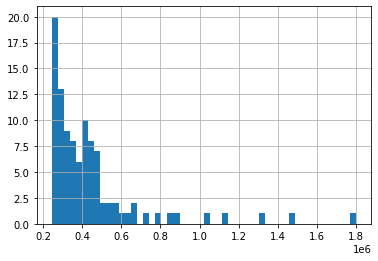

In [122]:
pivot.sum(axis=0).sort_values(ascending=False)[:100].hist(bins=50);

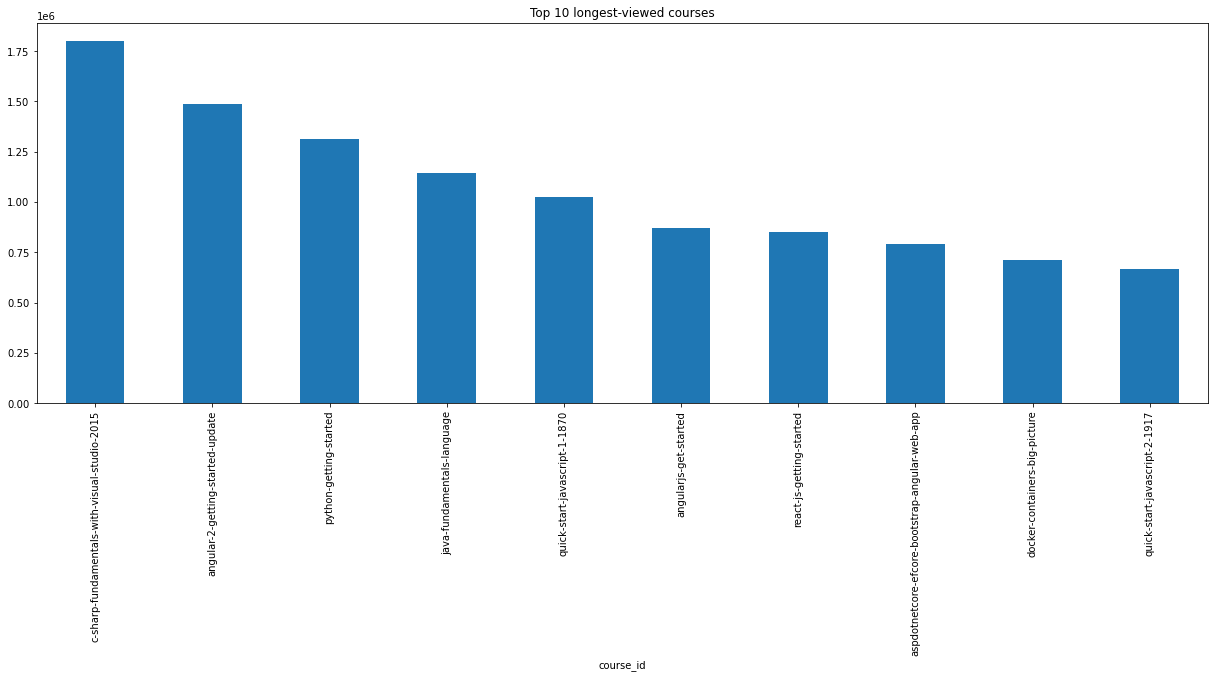

In [127]:
plt.figure(figsize=(21, 7))
pivot.sum(axis=0).sort_values(ascending=False)[:10].plot.bar()
plt.title("Top 10 longest-viewed courses");

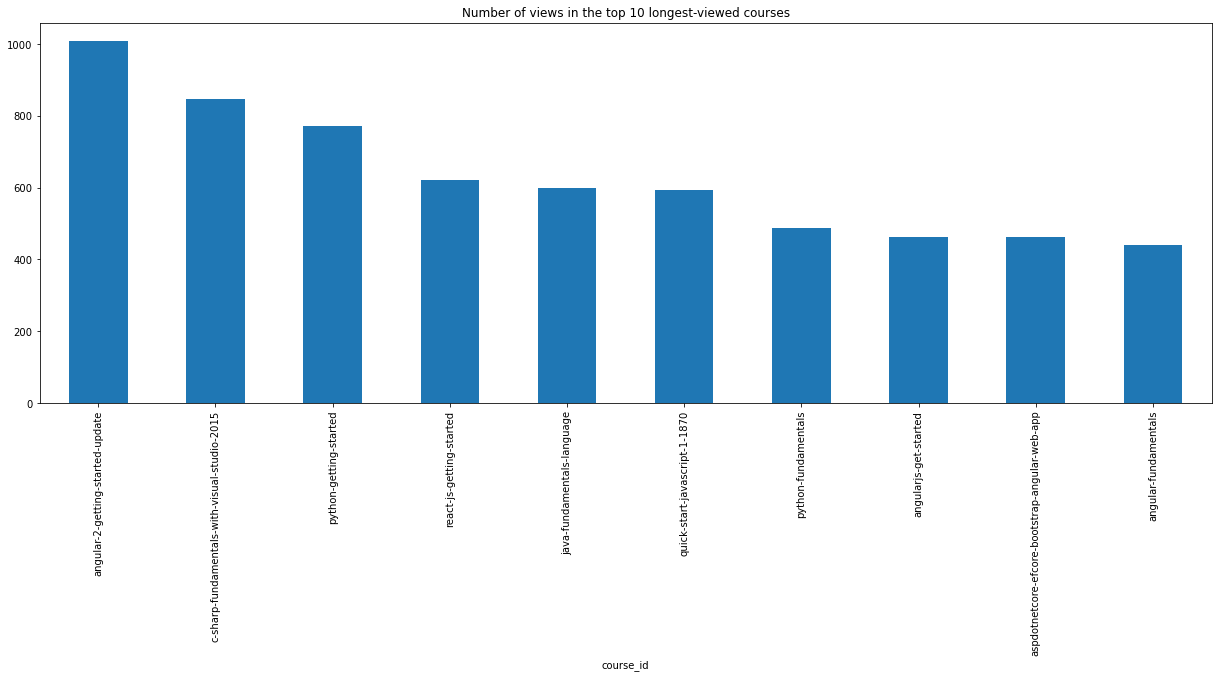

In [128]:
plt.figure(figsize=(21, 7))
(pivot > 0).sum(axis=0).sort_values(ascending=False)[:10].plot.bar()
plt.title("Number of views in the top 10 longest-viewed courses");

### Create a sparse matrix

In [129]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))
sparse_pivot

<8760x5942 sparse matrix of type '<class 'numpy.float64'>'
	with 105324 stored elements in Compressed Sparse Row format>

## Calculate the Cosine Similarity of the users' viewing time

In [135]:
similarities = cosine_similarity(sparse_pivot)
similarities

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00773652, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00773652, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Put into a dataframe

In [136]:
sim_users = pd.DataFrame(similarities, columns=pivot.index, index=pivot.index)
sim_users.head()

user_handle,1,2,3,4,5,6,8,9,10,12,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
user_handle,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.0,0.190064,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.157964,0.632888,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2,0.000000,1.000000,0.0,0.000000,0.073494,0.000000,0.0,0.0,0.014494,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.007737,0.0,0.0
3,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.459196,0.515684,0.000000,0.0,0.0
4,0.190064,0.000000,0.0,1.000000,0.000000,0.000161,0.0,0.0,0.029279,0.0,...,0.0,0.0,0.000000,0.000000,0.013636,0.131830,0.000000,0.000000,0.0,0.0
5,0.000000,0.073494,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


## Use this dataframe as the lookup table
Now we'll mimic what our API is to do:
1. User enters a term that becomes "search" in the below script
2. list the ten most similar users
3. list the average time viewed in hours (seconds * 3600)
4. list the number of courses viewed

In [150]:
search = '749'

for user in views.loc[views['user_handle']==int(search)]:
    print(user, search)
    print("10 closest users")
    print(sim_users[int(search)].sort_values()[1:11]) 

user_handle 749
10 closest users
user_handle
6647    0.0
6646    0.0
6645    0.0
6643    0.0
6642    0.0
6641    0.0
6640    0.0
6638    0.0
6637    0.0
6636    0.0
Name: 749, dtype: float64
view_date 749
10 closest users
user_handle
6647    0.0
6646    0.0
6645    0.0
6643    0.0
6642    0.0
6641    0.0
6640    0.0
6638    0.0
6637    0.0
6636    0.0
Name: 749, dtype: float64
course_id 749
10 closest users
user_handle
6647    0.0
6646    0.0
6645    0.0
6643    0.0
6642    0.0
6641    0.0
6640    0.0
6638    0.0
6637    0.0
6636    0.0
Name: 749, dtype: float64
author_handle 749
10 closest users
user_handle
6647    0.0
6646    0.0
6645    0.0
6643    0.0
6642    0.0
6641    0.0
6640    0.0
6638    0.0
6637    0.0
6636    0.0
Name: 749, dtype: float64
level 749
10 closest users
user_handle
6647    0.0
6646    0.0
6645    0.0
6643    0.0
6642    0.0
6641    0.0
6640    0.0
6638    0.0
6637    0.0
6636    0.0
Name: 749, dtype: float64
view_time_seconds 749
10 closest users
user_handle
66

## Use NLP to find the similar course_tags and assessment_tags and interest_tags

## Use OHE to vectorize categorical columns

## Use DBScan to create clusters of users

In [85]:
from sklearn.cluster import DBSCAN

In [89]:
db = DBSCAN(n_jobs=-1)

In [90]:
db.fit(users)

DBSCAN(n_jobs=-1)

In [92]:
db.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [93]:
users['dblabels'] = db.labels_

## Use Cosine Similarity Scores to compare the users to one another

In [94]:
from sklearn.metrics.pairwise import cosine_similarity

In [96]:
users.head(2)

,view_time_seconds,user_assessment_score,dblabels
user_handle,,,
1,3182060.0,0.0,-1
2,2685460.0,250756.0,-1


In [97]:
from sklearn.preprocessing import StandardScaler

In [102]:
sc = StandardScaler()

In [103]:
users_sc = sc.fit_transform(users)

In [106]:
users_sc = pd.DataFrame(users_sc)

In [107]:
users_sc.head()

,0,1,2
0,-0.022298,-0.038951,-0.339795
1,-0.024138,-0.020313,-0.339795
2,-0.033936,-0.038951,-0.339795
3,-0.032351,-0.035710,-0.339795
4,-0.021824,-0.038951,-0.339795


In [ ]:
#vectorize the dataframe?
#mean center the dataframe
#make it a df again
#cosine similarity


In [108]:
from scipy import sparse

## Save the dataframe to csv and consider DynamoDB, SQLite, PostreSQL, and AWS RDS